# Generate dataset

In this notebook dataset consisting of 1000000 patients (both indicators and tumor size charts) are generated using the original QSP model.

When for given patient indicators QSP returns an error, another indicators are generated.

The result is saved in `./final/dataset.npz`

In addition a metadata file (`./final/dataset_metadata.json`) is saved containing total times of generating patients indicators, tumor size time profiles and saving the result file.

Note: this notebook requires `R` in which the original QSP model is written. This model also requires package `deSolve` to be installed in `R`.

In [1]:
# number of patients in dataset
dataset_size = 1_000_000

In [2]:
# generating patient indicators
import numpy as np
import time

DISTRIBUTION_PARAMETERS = np.array(
    [
        [0.05, 0.5],
        [-2.436, 0.62335],
        [-2.58098, 0.69689],
        [0.2, 0.4],
        [0.005, 0.01],
        [0.01155, 0.0231],
        [0.15, 0.30],
        [150, 300],
        [0.75, 1.5],
        [1e-5, 0.01],
    ]
)
PARAMETER_NAMES = [
    "Fraction of leukocytes in tumour",
    "Fraction of cytotoxic T-cells in tumour",
    "Fraction of antigen presenting cells in tumour",
    "tumour growth rate",
    "Stroma growth rate",
    "tumour death rate",
    "tumour kill rate by cytotoxic T-cells",
    "The rate of cytotoxic T-cell exhaustion by PD1",
    "T-cell proliferation in lymph node",
    "Initial tumour volume"
]
LOGNORMAL_PARAMETERS = (1, 2)
np.random.seed(seed=42)


def generate_patient_indicators(size):
    generation_start_time = time.time()

    patient_indicators = np.zeros((size, 11))
    patient_indicators[:, 0] = np.ones(size)  # first indicator tells if treatment was applied

    for i, distribution_parameters in enumerate(DISTRIBUTION_PARAMETERS):
        if i in LOGNORMAL_PARAMETERS: 
            patient_indicators[:, i+1] = np.random.lognormal(mean=distribution_parameters[0], sigma=distribution_parameters[1], size=size)
        else:
            patient_indicators[:, i+1] = np.random.uniform(low=distribution_parameters[0], high=distribution_parameters[1], size=size)

    generation_time_s = time.time() - generation_start_time
    
    return patient_indicators, generation_time_s

patient_indicators, patient_indicators_generation_time_s = generate_patient_indicators(dataset_size)
    
print(f"Generated {dataset_size} sets of patients indicators in {patient_indicators_generation_time_s} seconds")

Generated 1000000 sets of patients indicators in 0.2636861801147461 seconds


In [3]:
# Displaying sample of indicators
from IPython.display import HTML, display
sample_size = min(dataset_size, 8)
html = f"<table><tr><th>Indicator</th><th>Distribution</th>{''.join(f'<th>p{i}</th>' for i in range(sample_size))}</tr>"
for i, indicator_name in enumerate(PARAMETER_NAMES):
    html += f"<tr><td>{indicator_name}</td><td>"
    if i in LOGNORMAL_PARAMETERS:
        html += f"lognormal(mean={DISTRIBUTION_PARAMETERS[i][0]}, sigma={DISTRIBUTION_PARAMETERS[i][1]})"
    else:
        html += f"uniform({DISTRIBUTION_PARAMETERS[i][0]}, {DISTRIBUTION_PARAMETERS[i][1]})"
    html += "</td>"
    html += "".join(f'<td>{patient_indicators[j,i+1]:.3f}</td>' for j in range(sample_size))
    html += "</tr>"
html += "</table>"
display(HTML(html))

Indicator,Distribution,p0,p1,p2,p3,p4,p5,p6,p7
Fraction of leukocytes in tumour,"uniform(0.05, 0.5)",0.219,0.478,0.379,0.319,0.120,0.120,0.076,0.440
Fraction of cytotoxic T-cells in tumour,"lognormal(mean=-2.436, sigma=0.62335)",0.030,0.186,0.088,0.082,0.092,0.159,0.062,0.117
Fraction of antigen presenting cells in tumour,"lognormal(mean=-2.58098, sigma=0.69689)",0.110,0.196,0.045,0.045,0.198,0.098,0.079,0.263
tumour growth rate,"uniform(0.2, 0.4)",0.204,0.227,0.353,0.350,0.394,0.204,0.353,0.343
Stroma growth rate,"uniform(0.005, 0.01)",0.005,0.010,0.009,0.009,0.007,0.008,0.006,0.009
tumour death rate,"uniform(0.01155, 0.0231)",0.012,0.014,0.017,0.018,0.023,0.021,0.021,0.017
tumour kill rate by cytotoxic T-cells,"uniform(0.15, 0.3)",0.206,0.201,0.191,0.265,0.171,0.299,0.232,0.201
The rate of cytotoxic T-cell exhaustion by PD1,"uniform(150.0, 300.0)",237.070,225.328,163.055,243.266,204.784,200.891,251.118,297.879
T-cell proliferation in lymph node,"uniform(0.75, 1.5)",1.187,1.312,1.025,1.347,1.274,1.481,0.872,0.776
Initial tumour volume,"uniform(1e-05, 0.01)",0.002,0.010,0.003,0.003,0.006,0.000,0.010,0.009


In [4]:
# importing model
import os
from contextlib import redirect_stderr, redirect_stdout
from io import StringIO

from multiprocess import Process, Queue, cpu_count

from rpy2 import robjects
from rpy2.rinterface_lib.embedded import RRuntimeError
from rpy2.robjects.packages import SignatureTranslatedAnonymousPackage


END_VALUE = "end"

def load_r_model():
    model_path = Path("../final/qspRPlusC/simulateQSP.R").resolve()
    cur_dir = os.path.abspath(os.path.curdir)
    try:
        os.chdir(model_path.parent)
        with model_path.open("r") as f_p:
            model = SignatureTranslatedAnonymousPackage(f_p.read(), "model")
    finally:
        os.chdir(cur_dir)
    return model

def calc_model_point(coord, model):
    stream = StringIO()
    err_stream = StringIO()
    try:
        with redirect_stdout(stream), redirect_stderr(err_stream):
            res = model.simulateQSP(robjects.FloatVector(coord))[0]
    except RRuntimeError as r_exception:
        raise ValueError(f"Error in simulation {r_exception.args[0]}") from r_exception
    stream.seek(0)
    err_stream.seek(0)
    if stream.read() or err_stream.read():
        # jezeli symulacja jest niestabilna model wypisuje tą informację na standardowe wyjście.
        # Wiec jeżeli jest jakiś tekst na standardowym wyjściu to uznajemy, że symulacja jest niestabilna.
        raise ValueError("Unstable simulation")
    index = list(res.names).index("Tumor_volume")
    return list(res[index])

def calc_model_point_mp(in_queue: Queue, out_queue: Queue):
    stream = StringIO()
    err_stream = StringIO()
    with redirect_stdout(stream), redirect_stderr(err_stream):
        model = load_r_model()

    while True:
        input_data = in_queue.get()
        if input_data == END_VALUE:
            return

        i, coord = input_data
        try:
            res = calc_model_point(coord, model)
            out_queue.put((i, res))
        except ValueError as e:
            res = [coord[10], *([100.0 * coord[10]] * 199)]
            out_queue.put((i, res))

def model_predict_with_progress(input_data, progress_bar) -> np.array:           
    in_queue = Queue()
    out_queue = Queue()
    process_list = []
    process_num = cpu_count()

    for _ in range(process_num):
        proc = Process(target=calc_model_point_mp, args=(in_queue, out_queue))
        proc.start()
        process_list.append(proc)

    time_profiles = np.empty((input_data.shape[0], 200))
    calculated = 0

    for i, coord in enumerate(input_data):
        in_queue.put((i, coord))

        if i > 10 * process_num:
            j, row = out_queue.get()
            time_profiles[j, :] = row
            calculated += 1
            if progress_bar is not None and row[0] * 100 != row[1]:
                progress_bar.update(1)

    while calculated < input_data.shape[0]:
        i, row = out_queue.get()
        time_profiles[i, :] = row
        calculated += 1
        if progress_bar is not None and row[0] * 100 != row[1]:
            progress_bar.update(1)

    for _ in range(process_num):
        in_queue.put(END_VALUE)

    for i in range(process_num):
        process_list[i].join()
        
    return time_profiles


In [5]:
# Testing model (generating time profiles for sample of patients)
from tqdm.notebook import tqdm

pbar = tqdm(total=sample_size)
sample_time_profiles = model_predict_with_progress(patient_indicators[:sample_size, :], pbar)
pbar.close()

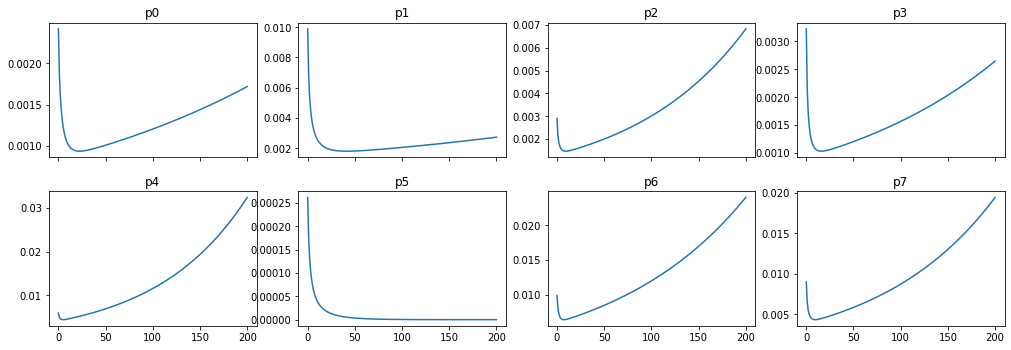

In [6]:
# displaying sample time profiles
%matplotlib inline
import matplotlib.pyplot as plt

x_axis = np.linspace(0, 200, sample_time_profiles.shape[1])

rows, cols = (sample_size + 3) // 4, 4
figure, axs = plt.subplots(rows, cols, sharex=True)
figure.set_size_inches(cols * 3.5, rows * 3)
figure.tight_layout(h_pad=2.4, rect=(0, 0, 1, 1.0 - 0.4 / rows))

for row in range(rows):
    for col in range(cols):
        i = row * cols + col
        if i < sample_size:
            axs[row, col].set_title(f"p{i}")
            axs[row, col].plot(x_axis, sample_time_profiles[i, :])

In [7]:
from tqdm.notebook import tqdm


with tqdm(total=dataset_size) as pbar:
    time_profiles_generate_start_time = time.time()
    time_profiles = model_predict_with_progress(patient_indicators, pbar)
    time_profiles_generation_time_s = time.time() - time_profiles_generate_start_time
    
    missing_indices = time_profiles[:, 0] * 100.0 == time_profiles[:, 1]
    missing_count = np.count_nonzero(missing_indices)
    
    while missing_count > 0:
        patient_indicators[missing_indices == True, :], generation_time_s = generate_patient_indicators(missing_count)
        patient_indicators_generation_time_s += generation_time_s
            
        time_profiles_generate_start_time = time.time()
        time_profiles[missing_indices == True, :] = model_predict_with_progress(patient_indicators[missing_indices == True, :], pbar)
        time_profiles_generation_time_s += time.time() - time_profiles_generate_start_time

        # on failed generation a profile [x, 100x, 100x, ..., 100x] is generated
        # also valid for not filled time profiles (zeros)
        missing_indices = time_profiles[:, 0] * 100.0 == time_profiles[:, 1]
        missing_count = np.count_nonzero(missing_indices)

In [8]:
from pathlib import Path

saving_start_time = time.time()
np.savez_compressed(
    Path('../final/dataset.npz'),
    inputs=np.array(patient_indicators, dtype=np.float32),
    outputs=np.array(time_profiles, dtype=np.float32),
    params='default',
)
saving_time_s = time.time() - saving_start_time
print(f"Saved indicators and time profiles in {saving_time_s:.3f}s")

Saved indicators and time profiles in 31.697s


In [9]:
import json
import cpuinfo

metadata = {
    'patient_indicators_generate_time_s': patient_indicators_generation_time_s,
    'time_profiles_generation_time_s': time_profiles_generation_time_s,
    'saving_time_s': saving_time_s,
    'dataset_size': dataset_size,
    'cpu_info': {k:v for k,v in cpuinfo.get_cpu_info().items() if k in ('arch', 'bits', 'brand_raw', 'count', 'l2_cache_size')}
}
with Path('../final/dataset_metadata.json').open("w") as opened_file:
    metadata_string = json.dumps(metadata, sort_keys=True, indent=4)
    opened_file.write(metadata_string)
    print(metadata_string)

{
    "cpu_info": {
        "arch": "X86_64",
        "bits": 64,
        "brand_raw": "Intel(R) Core(TM) i7-4980HQ CPU @ 2.80GHz",
        "count": 8,
        "l2_cache_size": 262144
    },
    "dataset_size": 1000000,
    "patient_indicators_generate_time_s": 0.26659202575683594,
    "saving_time_s": 31.696553945541382,
    "time_profiles_generation_time_s": 22173.783852100372
}
